In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

try:
    import jupyter_black

    jupyter_black.load()
except:
    print("black not installed")

# Environment / Setup Check

This notebook is for checking your environment setup.

You can execute this within Google Colab or your own environment.

Just run the notebook to verify the environment.


## Google Colab Check


In [2]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False

print(f"In colab: {IN_COLAB}")

In colab: False


In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Modify the following path to ensure data is stored at the correct location.

In [4]:
from pathlib import Path

if IN_COLAB:
    DATA_PATH = Path("/content/drive/MyDrive/cas-dl-module-genai-part2")
else:
    DATA_PATH = Path("/workspace/code/data")

Install `dl_genai_lectures` package with all necessary dependencies.

This package provides the environment of the exercises-repository, as well as helper- and utils modules: [Link](https://github.com/marco-willi/cas-dl-genai-exercises-fs2025)

The following code installs the package from a local repository (if available), otherwise it installs it from the exercise repository.

In [5]:
try:
    import dl_genai_lectures

    print("dl_genai_lectures installed, all good")
except ImportError as e:
    import os

    if Path("/workspace/code/src").exists():
        print("Installing from local repo")
        os.system("cd /workspace/code  && pip install .")
    else:
        print("Installing from git repo")
        os.system(
            "pip install git+https://github.com/marco-willi/cas-dl-genai-exercises-fs2025"
        )

dl_genai_lectures installed, all good


# Library Imports

We load all necessary packages.

In [6]:
# --- Standard library ---
import io
import os
from pathlib import Path

# --- Basic Packages ---
import numpy as np
import pandas as pd
import requests
import seaborn
from matplotlib import pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm

# --- Machine Learning ---
import sklearn
import tensorboard

# --- Pytorch ---
import datasets
import diffusers
import lightning as L
import torch
import torchinfo
import torchmetrics
import torchshow as ts
import torchvision
import transformers

# --- APIs ---
import huggingface_hub
import openai
import replicate
from google import genai

# --- Utils---
import gdown
import wandb
from dotenv import load_dotenv

# --- Local / course packages ---
import dl_genai_lectures

In [7]:
# Load environment variables and .env file (if available)
load_dotenv()

True

## Test Some Operations

Now we simply apply some of the packages that we imported.

We also test data storage on your drive.

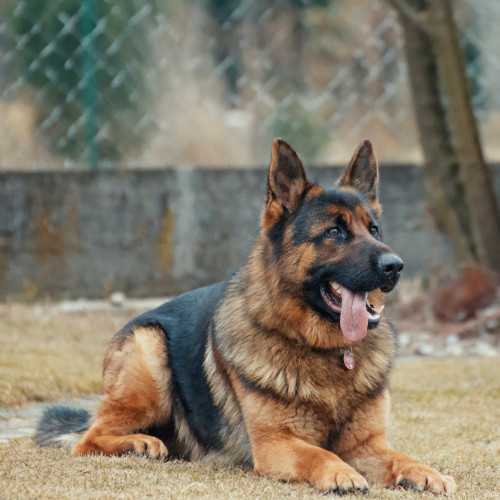

In [8]:
url = "https://github.com/pytorch/vision/blob/main/gallery/assets/dog2.jpg?raw=true"
r = requests.get(url, allow_redirects=True)
image = Image.open(io.BytesIO(r.content))
image

Now we save the image in `DATA_PATH`.

In [9]:
image_path = DATA_PATH.joinpath("dog.png")

image.save(image_path)

Now we load the image and display it.

In [10]:
from torchvision.io import read_image

image = read_image(image_path)

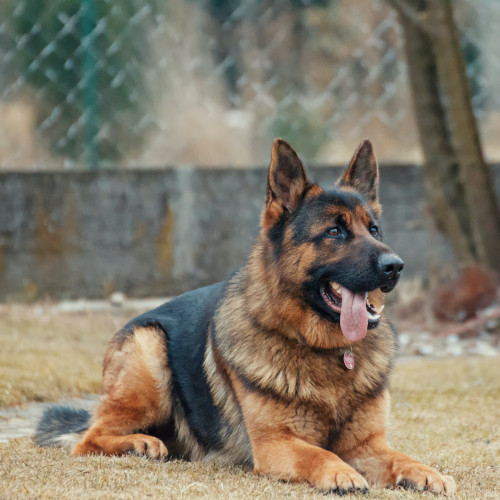

In [11]:
from torchvision.transforms import functional as F

F.to_pil_image(image)

# PyTorch Device Test

Simple test. Depending on your hardware and/or the instance that you are using it should be GPU or CPU.

In [12]:
# setting device on GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print()

# Additional Info when using cuda
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))
    print("Memory Usage:")
    print("Allocated:", round(torch.cuda.memory_allocated(0) / 1024**3, 1), "GB")
    print("Cached:   ", round(torch.cuda.memory_reserved(0) / 1024**3, 1), "GB")

Using device: cuda

NVIDIA GeForce RTX 4060 Laptop GPU
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## HuggingFace / Diffuser Test

In [13]:
from diffusers import DDPMPipeline

pipeline = DDPMPipeline.from_pretrained(
    "1aurent/ddpm-mnist", cache_dir=DATA_PATH.joinpath("HF_CACHE")
)
image = pipeline().images[0]
image

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

## Openai API Test (optional)

In [14]:
from openai import OpenAI

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

if OPENAI_API_KEY is None:
    OPENAI_API_KEY = input("Please enter your OpenAI API key: ")
    os.environ["GEMINI_API_KEY"] = OPENAI_API_KEY


client = OpenAI()

response = client.images.generate(
    model="dall-e-3",
    prompt="a white siamese cat",
    size="1024x1024",
    quality="standard",
    n=1,
    response_format="url",
)

print(response.data[0].url)

BadRequestError: Error code: 400 - {'error': {'message': 'Error in request. Please check your input.', 'type': 'invalid_request_error', 'param': None, 'code': None}}

## Google Gemini API Test (optional)

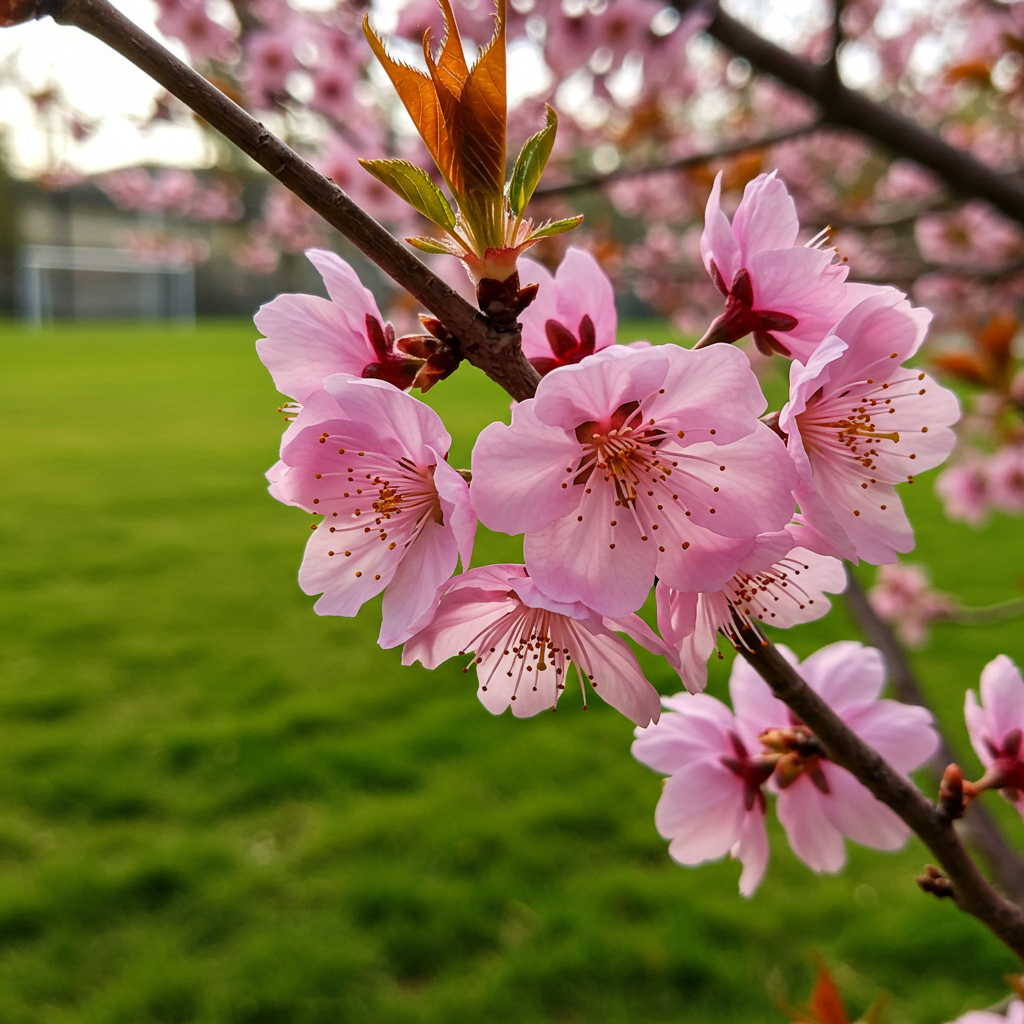

In [15]:
from google.genai import types

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

if GEMINI_API_KEY is None:
    GEMINI_API_KEY = input("Please enter your GEMINI_API_KEY key: ")
    os.environ["GEMINI_API_KEY"] = GEMINI_API_KEY

GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")

client = genai.Client(api_key=GEMINI_API_KEY)

response = client.models.generate_images(
    model="imagen-3.0-generate-002",
    prompt="a pink cherry blossom tree in front of a school sports field, close up, close-up intensity, delicate flowers, Nikon D90, 18mm, f/5",
    config=types.GenerateImagesConfig(
        number_of_images=1,
    ),
)
for generated_image in response.generated_images:
    image = Image.open(io.BytesIO(generated_image.image.image_bytes))
    image.show()

## Replicate API Test (Optional)

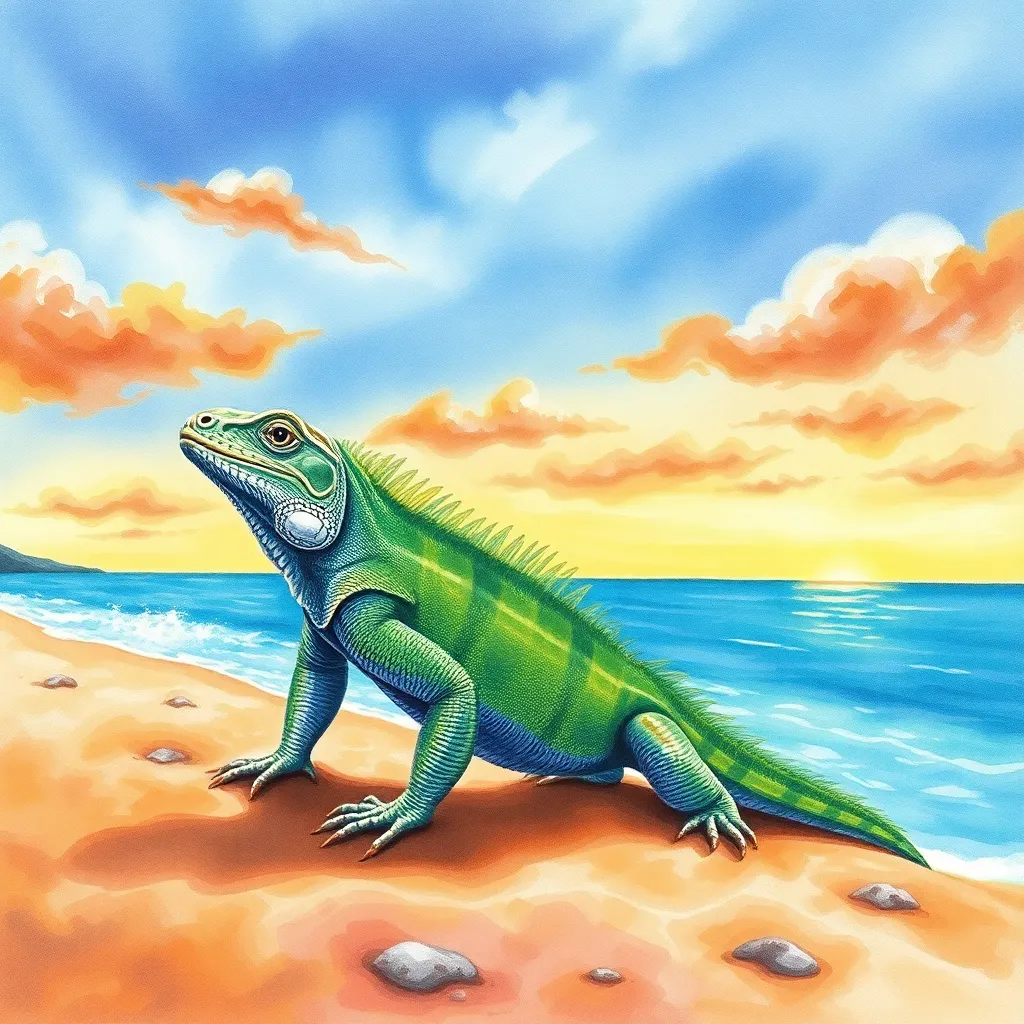

In [16]:
REPLICATE_API_TOKEN = os.getenv("REPLICATE_API_TOKEN")

if REPLICATE_API_TOKEN is None:
    REPLICATE_API_TOKEN = input("Please enter your OpenAI API key: ")
    os.environ["REPLICATE_API_TOKEN"] = REPLICATE_API_TOKEN


output = replicate.run(
    "black-forest-labs/flux-schnell",
    input={"prompt": "an iguana on the beach, pointillism"},
)

image_data = output[0].read()
image = Image.open(io.BytesIO(image_data))
image